# <centr>Description of this project </center>
## There are 14 subjects attending the experiments, they are indexed by following keys:
#['sub_0','sub_1', 'sub_2', 'sub_3', 'sub_4', 'sub_5', 'sub_6', 'sub_7', 'sub_8', 'sub_9'，'sub_10', 'sub_11', 'sub_12', 'sub_13',sub_13]




'''
all_datasets_len={'sub_0':6951, 'sub_1':7439, 'sub_2': 7686, 'sub_3': 8678, 'sub_4':6180, 'sub_5': 6671, 
                   'sub_6': 7600, 'sub_7': 5583, 'sub_8': 6032, 'sub_9': 6508, 'sub_10': 6348, 'sub_11': 7010, 'sub_12': 8049, 'sub_13': 6248}
all_datasets_ranges={'sub_-1':0, sub_0': 6951, 'sub_1': 14390, 'sub_2': 22076, 'sub_3': 30754, 'sub_4': 36934, 'sub_5': 43605,
                      'sub_6': 51205, 'sub_7': 56788, 'sub_8': 62820, 'sub_9': 69328, 'sub_10': 75676, 'sub_11':82686, 'sub_12': 90735, 'sub_13': 96983}
'''


# 1. Hyper parametes

In [12]:
## import necessary packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pdb
import os
import yaml
import h5py
print("tensorflow version:",tf.__version__)
# load datasets in a numpy 
import dp_lib as dp_lib

def initParameters():
    # hyper parameters
    hyperparams=dp_lib.hyperparams
    
    labels_names=[ 'L_IE', 'L_AA', 'L_FE','R_IE', 'R_AA', 'R_FE' ]
    
    '''
    features_names=[
        'L_Up_Acc_X', 'L_Up_Acc_Y', 'L_Up_Acc_Z', 'L_Up_Gyr_X', 'L_Up_Gyr_Y','L_Up_Gyr_Z',
        'L_Up_Mag_X','L_Up_Mag_Y','L_Up_Mag_Z',
        
        'L_Lower_Acc_X', 'L_Lower_Acc_Y', 'L_Lower_Acc_Z', 'L_Lower_Gyr_X', 'L_Lower_Gyr_Y','L_Lower_Gyr_Z',
        'L_Lower_Mag_X',   'L_Lower_Mag_Y','L_Lower_Mag_Z',
        
        'R_Up_Acc_X', 'R_Up_Acc_Y', 'R_Up_Acc_Z', 'R_Up_Gyr_X', 'R_Up_Gyr_Y','R_Up_Gyr_Z', 
        'R_Up_Mag_X', 'R_Up_Mag_Y', 'R_Up_Mag_Z',
        
        'R_Lower_Acc_X', 'R_Lower_Acc_Y', 'R_Lower_Acc_Z', 'R_Lower_Gyr_X', 'R_Lower_Gyr_Y','R_Lower_Gyr_Z', 
        'R_Lower_Mag_X',   'R_Lower_Mag_Y','R_Lower_Mag_Z'
        ]    
    
    '''
    
    # without magnetometer data
    features_names=[
        'L_Up_Acc_X', 'L_Up_Acc_Y', 'L_Up_Acc_Z', 'L_Up_Gyr_X', 'L_Up_Gyr_Y','L_Up_Gyr_Z', 
        
        'L_Lower_Acc_X', 'L_Lower_Acc_Y', 'L_Lower_Acc_Z', 'L_Lower_Gyr_X', 'L_Lower_Gyr_Y','L_Lower_Gyr_Z', 
        
        'R_Up_Acc_X', 'R_Up_Acc_Y', 'R_Up_Acc_Z', 'R_Up_Gyr_X', 'R_Up_Gyr_Y','R_Up_Gyr_Z', 
        
        'R_Lower_Acc_X', 'R_Lower_Acc_Y', 'R_Lower_Acc_Z', 'R_Lower_Gyr_X', 'R_Lower_Gyr_Y','R_Lower_Gyr_Z'
        ]    
    
    sub_idx=[0,1,2,3,4,5,6,7,8,9,10,11,12,13]
    #sub_idx=[0,1]
    
    columns_names=features_names+labels_names
    hyperparams['features_num']=len(features_names)
    hyperparams['labels_num']=len(labels_names)
    hyperparams['features_names']=features_names;
    hyperparams['labels_names']=labels_names
    hyperparams['learning_rate']=10e-2
    hyperparams['batch_size']=32
    hyperparams['window_size']=10
    hyperparams['epochs']=100
    hyperparams['columns_names']=columns_names
    hyperparams['raw_dataset_path']= './datasets_files/raw_datasets.hdf5'
    hyperparams['sub_idx']=sub_idx
    
    print('sub_idxs:',sub_idx)
    return hyperparams

if __name__=='__main__':
    pass
    #hyperparams=initParameters()
    #print("window size:", hyperparams['window_size'])

tensorflow version: 2.5.0


# 2. Prepare dataset for training and evaluation
## 2.1 Read raw subject data and normalization

In [13]:
from sklearn.preprocessing import StandardScaler

def load_normalize_data(sub_idx,scaler=None):
    
    #**** Single subject test
    if(isinstance(sub_idx,int)):
        start=dp_lib.all_datasets_ranges['sub_'+str(sub_idx-1)]
        end=dp_lib.all_datasets_ranges['sub_'+str(sub_idx)]
        series=dp_lib.read_rawdata(range(start,end),hyperparams['columns_names'],hyperparams['raw_dataset_path'])
        print("Raw data of subject {:}, rows from {:} to {:}".format(sub_idx,start,end))
    
    #**** Multiple subject data indexed by numbers
    if(isinstance(sub_idx,list) and isinstance(sub_idx[0],int)):
        start_sub_num=int(sub_idx[0])
        end_sub_num=int(sub_idx[-1])
        start=dp_lib.all_datasets_ranges['sub_'+str(start_sub_num-1)]
        end=dp_lib.all_datasets_ranges['sub_'+str(end_sub_num)]
        series=dp_lib.read_rawdata(range(start,end),hyperparams['columns_names'],hyperparams['raw_dataset_path'])
        print("Raw data of subject {:}, rows from {:} to {:}".format(sub_idx,start,end))
    
    #**** Multiple subject data indexed by "sub_num"
    if(isinstance(sub_idx,list) and isinstance(sub_idx[0],str)):
        series_temp=[]
        for idx in sub_idx:
            assert(isinstance(idx,str))
            series_temp.append(dp_lib.read_rawdata(idx,hyperparams['columns_names'],hyperparams['raw_dataset_path']))
        series=np.concatenate(series_temp,axis=0)
        print("Raw data of subject {:}".format(sub_idx))
    # load dataset
    print('Loaded dataset shape:',series.shape)
    
    #Normalization data
    if scaler==None:
        scaler=StandardScaler()
    scaler.fit(series)
    scaled_series=scaler.transform(series.astype(np.float32),copy=True)
    
    # Get the initial stage data of every subjects
    init_stage_sub_ranges={keys:range(dp_lib.all_datasets_ranges['sub_'+str(int(keys[4:])-1)],dp_lib.all_datasets_ranges['sub_'+str(int(keys[4:])-1)]+300)
                  for keys in ['sub_'+str(idx) for idx in range(14)]}
    init_stage_sub_data={keys:dp_lib.read_rawdata(values,hyperparams['columns_names'],hyperparams['raw_dataset_path']) for keys, values in init_stage_sub_ranges.items()}
    # Normalization of init-stage data
    scaled_init_stage_sub_data={keys:scaler.transform(values).mean(axis=0,keepdims=True) 
                                for keys, values in init_stage_sub_data.items()}
    #empirically_orientation=[-2.32, 2.77,-3.5,  -8.65, 4.0, 3.01, -0.22, -2.11, 5.29, -9.47, -2.85, -1.33]
    return scaled_series, scaler

if __name__=='__main__':
    pass
    #scaled_series,scaler=load_normalize_data(sub_idx=['sub_1','sub_2','sub_4'])



## 2.2 Split datasets into train, valid and test data

In [14]:
def split_dataset(scaled_series,sub_idx):
    #1) Split raw dataset into train, valid and test dataset
    if(isinstance(sub_idx,int)):# split single subject data 
        all_train_split={'sub_0':5600,'sub_1':6000,'sub_2':6400,'sub_3':7500,
                         'sub_4':4900,'sub_5':6000,'sub_6':4500,'sub_7':4500,
                         'sub_8':4900,'sub_9':5100,'sub_10':5000,'sub_11':5700,'sub_12':6400,'sub_13':4000}
        all_valid_split={'sub_0':6500,'sub_1':6800,'sub_2':7000,'sub_3':8100,
                         'sub_4':5600,'sub_5':6900,'sub_6':5100,'sub_7':5000,
                         'sub_8':5600,'sub_9':5900,'sub_10':5800,'sub_11':6200,'sub_12':7200, 'sub_13':4900}
        train_split = all_train_split['sub_'+str(sub_idx)]
        valid_split= all_valid_split['sub_'+str(sub_idx)]
    if(isinstance(sub_idx,list)):# split multiple subject data, using leave-one-out cross-validtion
        train_split=scaled_series.shape[0]-3000
        valid_split=scaled_series.shape[0]-2000
    
    xy_train = scaled_series[:train_split,:]
    xy_valid = scaled_series[train_split:valid_split,:]
    xy_test = scaled_series[valid_split:,:]
    shuffle_buffer_size = 6000
    
    
    # Sensor segment calibration transfer process
    Init_stage_calibration=False
    if(Init_stage_calibration):
        np.random.seed(101)
        transfer_weight=np.random.randn(features_num,features_num)
        transfer_temp=np.dot(scaled_init_stage_sub_data['sub_'+str(sub_idx)][:,:features_num],transfer_weight)
        xy_train[:,:features_num]=xy_train[:,:features_num]+np.tanh(transfer_temp)
        xy_valid[:,:features_num]=xy_valid[:,:features_num]+np.tanh(transfer_temp)
        xy_test[:,:features_num]=xy_test[:,:features_num]+np.tanh(transfer_temp)
        # init info fom calibration stage 
        xy_train_init=scaled_init_stage_sub_data['sub_'+str(sub_idx)]*np.ones(xy_train.shape)
        xy_valid_init=scaled_init_stage_sub_data['sub_'+str(sub_idx)]*np.ones(xy_valid.shape)
        xy_test_init=scaled_init_stage_sub_data['sub_'+str(sub_idx)]*np.ones(xy_test.shape)
    
    print("Subject {:} dataset".format(sub_idx))
    print("xy_train shape:",xy_train.shape)
    print("xy valid shape:",xy_valid.shape)
    print("xy_test shape:",xy_test.shape)
    
    return xy_train, xy_valid,xy_test
    
    
if __name__=='__main__':
    pass
    #xy_train, xy_valid, xy_test = split_dataset(scaled_series,sub_idx=[1,2])
    #hyperparams['train_sub_idx']=[1,2,4]

## 2.3 Transfer data into dataset for feeding to neural network

In [15]:

# packing data into windows 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    #series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:,:-6], w[:,-6:]))
    ds=ds.batch(batch_size).prefetch(1)
    return ds

# model prediction
def model_forecast(model, series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series[:,:-6])
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    #print(list(ds.as_numpy_iterator())[0])
    # model_prediction
    forecast = model.predict(ds)
    return forecast


if __name__=='__main__':
    # transfer the data into dataset for feeding to neural network
    pass
    #train_set = windowed_dataset(xy_train, hyperparams['window_size'], hyperparams['batch_size'], shuffle_buffer=1000)
    #valid_set = windowed_dataset(xy_valid, hyperparams['window_size'], hyperparams['batch_size'], shuffle_buffer=1000)
    #train_set_init = tf.data.Dataset.from_tensor_slices(xy_train_init).batch(1).map(lambda x: (x[:,:-6],x[:,-6:]))
    #valid_set_init = tf.data.Dataset.from_tensor_slices(xy_valid_init).batch(1).map(lambda x: (x[:,:-6],x[:,-6:]))
    #test_set_init = windowed_dataset(xy_test_init,window_size,batch_size,shuffle_buffer_size)

    



In [5]:
# display datasets

#datasets_ranges=(fnn_model_v3.all_datasets_ranges['sub_'+str(sub_idx-1)],fnn_model_v3.all_datasets_ranges['sub_'+str(sub_idx)])
#fnn_model_v3.display_rawdatase(series[31000:34000,:], columns_names, norm_type=None, raw_datasets_path=raw_dataset_path,plot_title='sub_'+str(sub_idx))
#fnn_model_v3.display_rawdatase(scaled_series[6000:6250,:], columns_names, norm_type=None, raw_datasets_path=raw_dataset_path,plot_title='sub_'+str(sub_idx))
#fnn_model_v3.display_rawdatase(scaler.inverse_transform(scaled_series[6000:6250,:]), columns_names, norm_type=None, raw_datasets_path=raw_dataset_path)
#fnn_model_v3.display_rawdatase(datasets_ranges, columns_names, norm_type='mean_std', raw_datasets_path=raw_dataset_path,plot_title='raw data')


# 3. Model definition
## 3.1 Model v1

In [6]:
# Model definne
def model_v1(hyperparams):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, hyperparams['features_num']]),
      tf.keras.layers.LSTM(60, return_sequences=True),
      tf.keras.layers.LSTM(60, return_sequences=True),
      #tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(60, activation="relu"),
      tf.keras.layers.Dense(30),
      tf.keras.layers.Dense(6)
      #tf.keras.layers.Lambda(lambda x: x *180)
    ])
    return model

# Callback class
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epcoh, logs={}):
        if(logs.get('loss')<0.003):
            print('\nLoss is low so cancelling training!')
            self.model.stop_training = True


if __name__=='__main__':
    pass
    #model=model_v1(hyperparams)
    #print(model.summary())
#training_folder=dp_lib.create_training_files(hyperparams=dp_lib.hyperparams)
#model summary


## 3.2 Model V2

In [7]:
# 定义组合神经网络，多个子网络

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

def model_v2():
    print(tf.__version__)
    ####定义一个方便构造常规 Sequential() 网络的函数
    def DNN_A_Graph(x,n_input=36,n_output=6,name='Transfer_graph'):
        tf.random.set_seed(50)
        np.random.seed(50)
        he = tf.initializers.he_normal()
        elu = tf.nn.elu
        x=Dense(n_input, kernel_initializer=he, activation=elu,name=name+'_1')(x)
        x=Dense(n_output,kernel_initializer=he, activation=elu,name=name+'_2')(x)
        return(x)
    
    def DNN_B_Graph(x,n_input=36,n_output=6,name='Main_graph'):
        ##
        x=tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[window_size, features_num],name='Conv1D')(x)
        x=tf.keras.layers.LSTM(60, return_sequences=True,name='lstm_1')(x)
        x=tf.keras.layers.LSTM(60, return_sequences=True,name='lstm_2')(x)
        x=tf.keras.layers.Flatten()(x)
        x=tf.keras.layers.Dense(60, activation="relu")(x)
        x=tf.keras.layers.Dense(30)(x)
        x=tf.keras.layers.Dense(6)(x)
        return(x)
        
        
    #### 构造并联网络图
    ##需要并联的两个网络的输入
    input_a=tf.keras.layers.Input(shape=[features_num],name='Input_A')
    input_b=tf.keras.layers.Input(shape=[hyperparams['window_size'],features_num],name='Input_B')
    window_size=hyperparams['window_size']
    ##构造两个需要并联的子网络结构
    dnn_a=DNN_A_Graph(input_a,n_input=features_num,n_output=labels_num,name="DNN_A")
    dnn_b=DNN_B_Graph(input_b,n_input=features_num,n_output=labels_num,name="DNN_B")
    ##concat操作
    concat=tf.keras.layers.concatenate([dnn_a,dnn_b],axis=-1,name="Concat_Layer")
    ##在concat基础上继续添加一些层
    output=Dense(labels_num,name="Output_Layer")(concat)
    ##这一步很关键：这一步相当于把输入和输出对应起来，形成系统认识的一个完整的图。
    model_v2=Model(inputs=[input_a,input_b],outputs=[output])
    model_v2.get_layer('DNN_A_1').trainable=False
    model_v2.get_layer('DNN_A_2').trainable=False
    
    ##网络的其他组件
    optimizer=tf.keras.optimizers.Adam()
    loss_fn=tf.keras.losses.mean_squared_error
    model_v2.compile(loss=loss_fn,
                  optimizer=optimizer,
                  metrics=['accuracy'],
                  )
    
    model_v2.summary()
    #### 训练和测试：这里的x1,x2,对应前述的input_a和input_b
    #model.fit(x=[x1,x2],y=y,epochs=10,batch_size=500,verbose=2)
    
    #model.evaluate(x=[x1_test,x2_test],y=y_test,verbose=2)
    return model_v2

# find optimal lr

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])


plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 2])


plt.plot(history.history['loss'])

# 4. Train model
## 4.1 Train model V1

In [8]:

def train_model(model,hyperparams,train_set,valid_set,training_mode='Integrative_way'):
    # train model_v1
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)
    
    # Instance callback
    callbacks=myCallback()
    
    # Crerate train results folder
    training_folder=dp_lib.create_training_files(hyperparams=hyperparams)
    
    # register tensorboard writer
    sensorboard_file=training_folder+'/tensorboard/'
    if(os.path.exists(sensorboard_file)==False):
        os.makedirs(sensorboard_file)
    summary_writer=tf.summary.create_file_writer(sensorboard_file)
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=hyperparams['learning_rate'], momentum=0.9)
    
    """ Integrated mode   """
    if training_mode=='Integrative_way':
        model.compile(loss=tf.keras.losses.Huber(),
                      optimizer=optimizer,
                      metrics=["mae"])
        history = model.fit(train_set,epochs=hyperparams['epochs'],validation_data=valid_set,callbacks=[callbacks])
        history_dict=history.history
    """ Specified mode   """
    if training_mode=='Manual_way':
        tf.summary.trace_on(profiler=True) # 开启trace
        for batch_idx, (X,y_true) in enumerate(train_set): 
            with tf.GradientTape() as tape:
                y_pred=model(X)
                loss=tf.reduce_mean(tf.square(y_pred-y_true))
                # summary writer
                with summary_writer.as_default():
                    tf.summary.scalar('loss',loss,step=batch_idx)
            # calculate grads
            grads=tape.gradient(loss, model.variables)
            # update params
            optimizer.apply_gradients(grads_and_vars=zip(grads,model.variables))
        # summary trace
        history_dict={"loss":'none'}
        with summary_writer.as_default():
            tf.summary.trace_export(name='model_trace',step=0,profiler_outdir=sensorboard_file)
    
    
    # Save trained model and its parameters, history 
    save_trainedModel(model,history_dict,training_folder)
    return model, history_dict, training_folder

# Save trained model
def save_trainedModel(trained_model,history_dict,training_folder,**args):
    # Load hyperparameters 
    hyperparams_file=training_folder+"/hyperparams.yaml"
    if os.path.isfile(hyperparams_file):
        fr = open(hyperparams_file, 'r')
        hyperparams = yaml.load(fr,Loader=yaml.BaseLoader)
        fr.close()
    # sub_idx of the subjects for training 
    train_sub_idx=hyperparams['train_sub_idx']
    train_sub_idx_str=''
    for ii in train_sub_idx:
        train_sub_idx_str+='_'+str(ii)
    # Save weights and models
     #-----
    
    # checkpoints
    checkpoint_folder=training_folder+'/checkpoints/'
    if(os.path.exists(checkpoint_folder)==False):
        os.makedirs(checkpoint_folder)
    checkpoint_name='my_checkpoint_sub'+train_sub_idx_str+'.ckpt'
    checkpoint=tf.train.Checkpoint(myAwesomeModel=model)
    checkpoint_manager=tf.train.CheckpointManager(checkpoint,directory=checkpoint_folder,
                                                  checkpoint_name=checkpoint_name,max_to_keep=20)
    checkpoint_manager.save()
    
        
    #saved_model
    saved_model_folder=training_folder+'/saved_model/'
    if(os.path.exists(saved_model_folder)==False):
        os.makedirs(saved_model_folder)
    saved_model_file=saved_model_folder+'my_model_sub'+train_sub_idx_str+'.h5'
    trained_model.save(saved_model_file)
    
    # save history
    import json
    # Get the dictionary containing each metric and the loss for each epoch
    history_path= training_folder+'/train_process/my_history_sub'+train_sub_idx_str
    # Save it under the form of a json file
    with open(history_path,'w') as fd:
        json.dump(history_dict, fd)
    # load history
    #history_dict = json.load(open(history_path, 'r'))
    
    
    
if __name__=='__main__':
    pass
    #trained_model,history, training_folder=train_model(model,hyperparams,train_set,valid_set)

## 4.2 Train model V2

In [9]:
def train_model_v2():
    # train model_v2
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)
    callbacks=myCallback()
    history = model_v2.fit([xy_train_init,train_set],epochs=150),#validation_data=[valid_set_init,valid_set],callbacks=[callbacks])
    return history


## 4.3 Plot training process

In [10]:
def plot_history(history_dict):
    print(history_dict.keys())
    plt.plot(history_dict['loss'],'r')
    plt.plot(history_dict['val_loss'],'g')
    plt.plot(history_dict['mae'])
    plt.legend(['train loss', 'valid loss','mae'])
    
    #plt.axis([0,150, 0.0,0.035])
    print('max train MAE: {:.4f} and max val MAE: {:.4f}'.format(max(history_dict['mae']),max(history_dict['val_mae'])))

# 5. Test model

In [11]:
import copy
def test_model(training_folder, xy_test,scaler,**args):
    
    #1) Crerate test results folder
    testing_folder=dp_lib.create_testing_files(training_folder)
    
    #2) Load hyperparameters, Note the values in hyperparams become string type
    hyperparams_file=training_folder+"/hyperparams.yaml"
    if os.path.isfile(hyperparams_file):
        fr = open(hyperparams_file, 'r')
        hyperparams = yaml.load(fr,Loader=yaml.BaseLoader)
        fr.close()

    
    #3) sub_idx of the subjects for training 
    train_sub_idx=hyperparams['train_sub_idx']
    train_sub_idx_str=''
    for ii in train_sub_idx:
        train_sub_idx_str+='_'+str(ii)
        
    #4) Load model
    saved_model_file=training_folder+'/saved_model/my_model_sub'+train_sub_idx_str+'.h5'
    #saved_model_file=training_folder+'/saved_model/my_model_sub_'+'0123456789a'+'.h5'
    #print(saved_model_file)
    trained_model=tf.keras.models.load_model(saved_model_file)
    
    #5) Test data
    model_output = model_forecast(trained_model, xy_test, 
                                  int(hyperparams['window_size']), int(hyperparams['batch_size']))
    model_prediction=np.row_stack([model_output[:-1,0,:],model_output[-1,0:,:]])
    
    
    #print("Test dataset shape:",xy_test.shape)
    #print("Model output shape",model_output.shape)
    #print("Model prediction shape",model_prediction.shape)
    
    #6) Reshape and inverse normalization
    prediction_xy_test=copy.deepcopy(xy_test) # deep copy of test data
    prediction_xy_test[:,-6:]=model_prediction # using same shape with all datasets
    predictions = scaler.inverse_transform(prediction_xy_test)[:,-6:] # inversed norm predition
    labels  = scaler.inverse_transform(xy_test)[:,-6:]
    features= scaler.inverse_transform(xy_test)[:,:-6]
    
    save_testResult(features,labels,predictions,testing_folder)
    
    return features,labels,predictions,testing_folder

# save test results
def save_testResult(features,labels,predictions,testing_folder):
    saved_test_results_file=testing_folder+"/test_results"+'.h5'
    with h5py.File(saved_test_results_file,'w') as fd:
        fd.create_dataset('features',data=features)
        fd.create_dataset('labels',data=labels)
        fd.create_dataset('predictions',data=predictions)

if __name__=='__main__':
    pass
    #features, labels, predictions,testing_folder = test_model(training_folder,xy_test,scaler)
    #print("labels shape",labels.shape)
    #print("features shape",features.shape)
    #print("Prediction shape",predictions.shape)

# 6. Plot results for paper
## 6.1 Estimation accuracy 

In [42]:
import re

testing_folder='./model/test_2020'
training_folder=testing_folder+"/../training_"+re.search(r"\d+$",testing_folder).group()
print(training_folder)

./model/test_2020/../training_2020


In [51]:
def plot_prediction(features,labels,predictions,testing_folder):
    
    # Evaluate using two metrics, mae and mse
    mae=tf.keras.metrics.mean_absolute_error(labels, predictions).numpy()
    
    mse=tf.keras.metrics.mean_squared_error(labels, predictions).numpy()
    print('MAE: {:.3f}, RMSE:{:.3f} \n of six joint angles in 2.5 seconds'.format(np.mean(mae),np.mean(np.sqrt(mse))))
    
    
    # Load hyperparameters, Note the values in hyperparams become string type
    print(testing_folder)
    training_folder=testing_folder+"/../training_"+re.search(r"\d+/$",testing_folder).group()
    hyperparams_file=training_folder+"/hyperparams.yaml"
    if os.path.isfile(hyperparams_file):
        fr = open(hyperparams_file, 'r')
        hyperparams = yaml.load(fr,Loader=yaml.BaseLoader)
        fr.close()
    
    # hyper parameters    
    features_names=hyperparams['features_names']
    labels_names=hyperparams['labels_names']
    
    
    # Save plot results
    #sub_idx=15
    test_sub_idx=hyperparams['test_sub_idx']
    test_sub_idx_str=''
    for ii in test_sub_idx:
        test_sub_idx_str+='_'+str(ii)
        
    prediction_file=testing_folder+'/sub'+test_sub_idx_str+'_estimation.svg'
    prediction_error_file=testing_folder+'/sub'+test_sub_idx_str+'_estimation_error.svg'
    
    
    # Plot the estimation results and errors
    dp_lib.plot_test_results(features, labels, predictions, features_names, labels_names,testing_folder,
                                   prediction_file=prediction_file,prediction_error_file=prediction_error_file)

if __name__=='__main__':
    pass
    #plot_prediction(features,labels,predictions,testing_folder)


## 6.2 Statistical plots

In [9]:
import pandas as pd
import seaborn as sns
    
def plot_prediction_statistic(features, labels, predictions):
    # Plot the statistical results of the estimation results and errors
    
    error=abs(predictions-labels)
    pd_error=pd.DataFrame(data=error,columns=labels_names)
    NRMSE=100.0*np.sqrt(pd_error.apply(lambda x: x**2).mean(axis=0).to_frame().transpose())/(labels.max(axis=0)-labels.min(axis=0))
    #*np.ones(pd_error.shape)*100
    pd_NRMSE=pd.DataFrame(data=NRMSE, columns = [col for col in list(pd_error.columns)])
    
    
    # create experiment results folder
    # MAE
    fig=plt.figure(figsize=(10,2))
    style = ['darkgrid', 'dark', 'white', 'whitegrid', 'ticks']
    sns.set_style(style[4],{'grid.color':'k'})
    sns.catplot(data=pd_error,kind='bar', palette="Set3").set(ylabel='Absolute error [deg]')
    #plt.text(2.3,1.05, r"$\theta_{ae}(t)=abs(\hat{\theta}(t)-\theta)(t)$",horizontalalignment='center', fontsize=20)
    savefig_file=basepath+'/sub_'+str(sub_idx)+'_mae.svg'
    plt.savefig(savefig_file)
    
    
    # NRMSE
    fig=plt.figure(figsize=(10,3))
    sns.catplot(data=pd_NRMSE,kind='bar', palette="Set3").set(ylabel='NRMSE [%]')
    #plt.text(2.3, 2.6, r"$NRMSE=\frac{\sqrt{\sum_{t=0}^{T}{\theta^2_{ae}(t)}/T}}{\theta_{max}-\theta_{min}} \times 100\%$",horizontalalignment='center', fontsize=20)
    savefig_file=basepath+'/sub_'+str(sub_idx)+'_nrmse.svg'
    plt.savefig(savefig_file)
    
    
    

# Main function 1 --- training and testing model

In [44]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
import time as localtimepkg



# Setup hyperparameters
hyperparams=initParameters()

# normalize all subject data

def normalize_subjects_data(sub_idxs):
    assert(isinstance(sub_idxs,list))
    xy_data, scaler = load_normalize_data(['sub_'+str(ii) for ii in sub_idxs])
    subject_data_len=dp_lib.all_datasets_len
    
    norm_subs_data={}
    start,end=0,0
    for ii, sub_idx in enumerate(sub_idxs):
        sub_idx_str='sub_'+str(sub_idx)
        if(ii==0):
            start=0
        else:
            start=end
        end+=subject_data_len[sub_idx_str]
        
        norm_subs_data[sub_idx_str]=xy_data[start:end,:]
    return norm_subs_data, scaler


# A list of training and testing files
train_test_folder= "./models_parameters_results/"+str(localtimepkg.strftime("%Y-%m-%d", localtimepkg.localtime()))
if(os.path.exists(train_test_folder)==False):
    os.makedirs(train_test_folder)    
train_test_folder_log=train_test_folder+"/train_test_folder.log"
if(os.path.exists(train_test_folder_log)):
    os.remove(train_test_folder_log)
log_dict={'training_folder':[],'testing_folder':[]}

# load and normalize datasets for training and testing
norm_subs_data, scaler=normalize_subjects_data(hyperparams['sub_idx'])
# leave-one-out cross-validation
loo = LeaveOneOut()
for train_index, test_index in loo.split(hyperparams['sub_idx']):
    
    # train and test subject dataset 
    print("TRAIN:", train_index, "TEST:", test_index)
    hyperparams['train_sub_idx']=[str(ii) for ii in  train_index] # the values of params should be str or int types
    hyperparams['test_sub_idx']=[str(ii) for ii in test_index]
    xy_train=[norm_subs_data['sub_'+str(ii)] for ii in train_index]
    xy_test=[norm_subs_data['sub_'+str(ii)] for ii in test_index]
    
    xy_train=np.concatenate(xy_train,axis=0)
    xy_test=np.concatenate(xy_test,axis=0)
    xy_valid=xy_test
    
    #1) load dataset
    train_set = windowed_dataset(xy_train, hyperparams['window_size'], hyperparams['batch_size'], shuffle_buffer=1000)
    valid_set = windowed_dataset(xy_valid, hyperparams['window_size'], hyperparams['batch_size'], shuffle_buffer=1000)
    print("Train set shape",xy_train.shape)
    print("Valid set shape",xy_valid.shape)
    print("Test set shape",xy_test.shape)
    #print("X Shape for a iteration train",list(train_set.as_numpy_iterator())[0][0].shape)
    #print("Y Shape for a iteration train",list(train_set.as_numpy_iterator())[0][1].shape)

    #2) declare model
    model=model_v1(hyperparams)
    
    #3) train model
    trained_model,history_dict,training_folder=train_model(model,hyperparams,train_set,valid_set)
    
    #4) test model
    features, labels, predictions, testing_folder = test_model(training_folder,xy_test,scaler)
    log_dict['training_folder'].append(training_folder)
    log_dict['testing_folder'].append(testing_folder)
     
    #5) Plot
    #plot_prediction(features,labels,predictions,testing_folder)
    #plot_prediction_statistic(features, labels, predictions)


#6) save train and test folder path
with open(train_test_folder_log,'w') as fd:
    yaml.dump(log_dict,fd)

sub_idxs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Raw data of subject ['sub_0', 'sub_1', 'sub_2', 'sub_3', 'sub_4', 'sub_5', 'sub_6', 'sub_7', 'sub_8', 'sub_9', 'sub_10', 'sub_11', 'sub_12', 'sub_13']
Loaded dataset shape: (96983, 30)
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
Train set shape (90032, 30)
Valid set shape (6951, 30)
Test set shape (6951, 30)


NameError: name 'model_v1' is not defined

In [ ]:
cpus=tf.config.list_logical_devices(device_type='CPU')
gpus=tf.config.list_logical_devices(device_type='GPU')
print(cpus,gpus)

print(hyperparams)

In [ ]:
import json
history_file='/home/sun/Downloads/my_history_sub_0_1_2_3_5'
with open(history_file,'r') as fd:
    his=json.load(fd)
    
    
plot_history(history_dict)

# Main function 1 --- training and testing model


tensorflow version: 2.5.0
sub_idxs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
./models_parameters_results/2021-08-11/test_061028/test_1/test_results.h5
MAE: 3.297, RMSE:4.287 
 of six joint angles in 2.5 seconds
./models_parameters_results/2021-08-11/test_061028/
Plot the test results
mean: {:.2f}, std: {:.2f}, rsme: {:.2f} [-0.55689085 -2.1851325  -2.1819696  -1.0650713   0.9115066   4.1432    ] [3.2050385 2.0799928 6.6738615 4.5471287 2.4921582 7.10799  ] [3.2530627 3.0168178 7.0214963 4.6701946 2.6536224 8.227371 ]


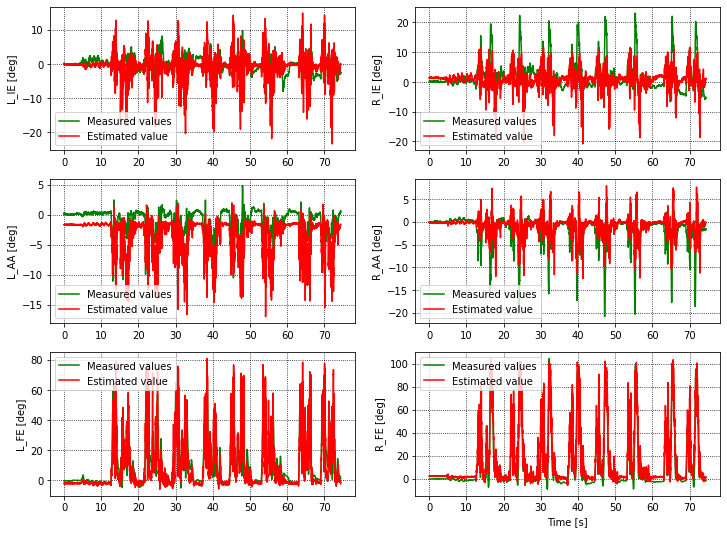

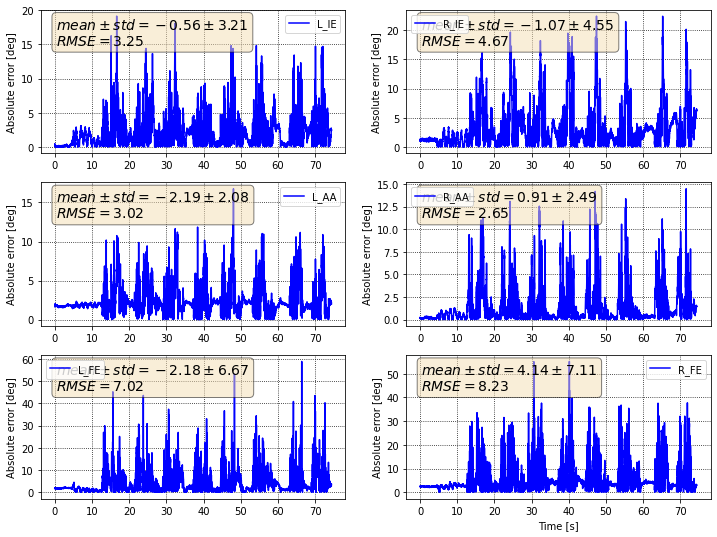

NameError: name 'labels_names' is not defined

In [52]:
## import necessary packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pdb
import os
import yaml
import h5py
print("tensorflow version:",tf.__version__)
# load datasets in a numpy 
import dp_lib as dp_lib


if __name__=='__main__':
    hyperparams=initParameters()
    #1) test model
    testing_folder='./models_parameters_results/2021-08-11/test_061028/'
    training_folder='./models_parameters_results/2021-08-11/training_061028/'
    if(testing_folder==None):
        features, labels, predictions, testing_folder = test_model(training_folder,xy_test,scaler)
        log_dict['training_folder'].append(training_folder)
        log_dict['testing_folder'].append(testing_folder)
    else:
        testing_results=testing_folder+'test_1/test_results.h5'
        print(testing_results)
        with h5py.File(testing_results,'r') as fd:
            features=fd['features'][:,:]
            predictions=fd['predictions'][:,:]
            labels=fd['labels'][:,:]

    plot_prediction(features,labels,predictions,testing_folder)
    plot_prediction_statistic(features, labels, predictions)